<a href="https://colab.research.google.com/github/peppefdf/CSL_Gipuzkoa/blob/main/mTSP_CPLEX_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
32394
23
32395
23
32396
6
32397
6
32398
6
32399
6
32400
6
32401
6
32402
13
32403
13
32404
18
32518
24
32519
24
32566
8
32567
8
32568
8
32580
8
32581
8
32582
8
32583
8
32584
8
32585
8
32604
6
32605
6
32606
6
32607
6
32608
6
32609
6
32610
6

Generating graph...
Graph completed!

Adding edge speeds, lengths and travelling speeds...
Adding edge speeds, lengths and travelling speeds completed!

Calculating distance matrix...
Distance matrix calculated!
La matriz de distancia es:

[[ 0.      0.2991  1.1527  1.4304  1.9801  2.5455  3.0812  3.2393  3.0051
   3.8845  6.0864  6.7291  9.0868]
 [ 0.2991  0.      1.4518  1.7295  2.2791  2.8446  3.3803  3.5384  3.3042
   4.1836  6.3855  7.0282  9.3859]
 [ 1.1527  1.4518  0.      0.2776  0.8273  1.3928  1.9285  2.1623  1.9281
   2.8076  5.0094  5.6521  8.0098]


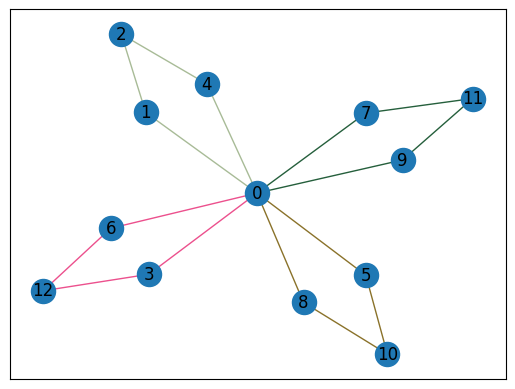

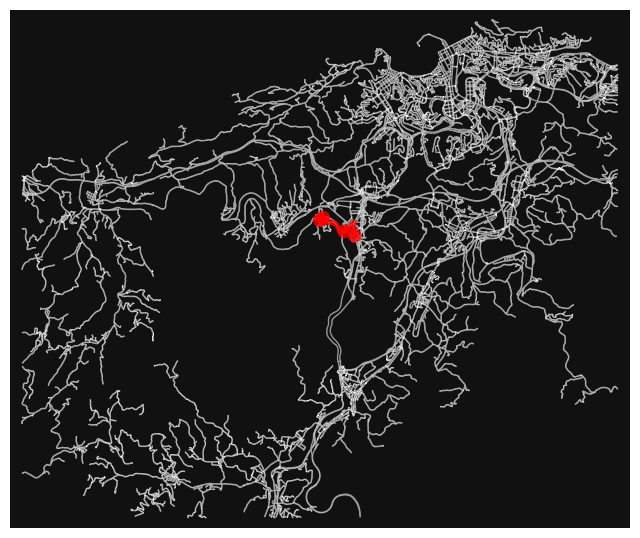

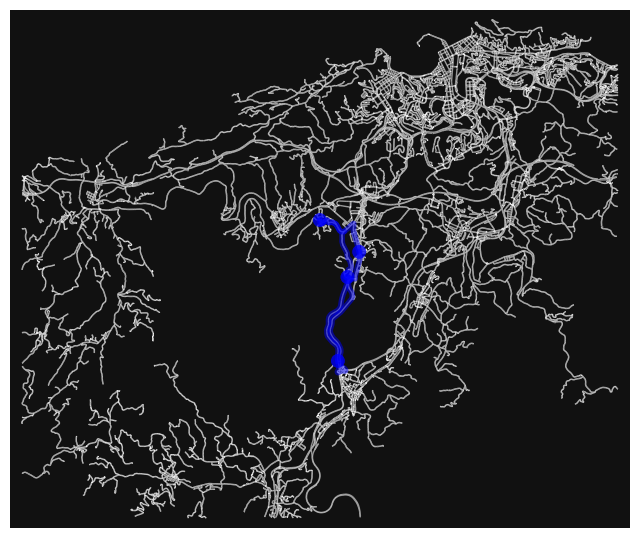

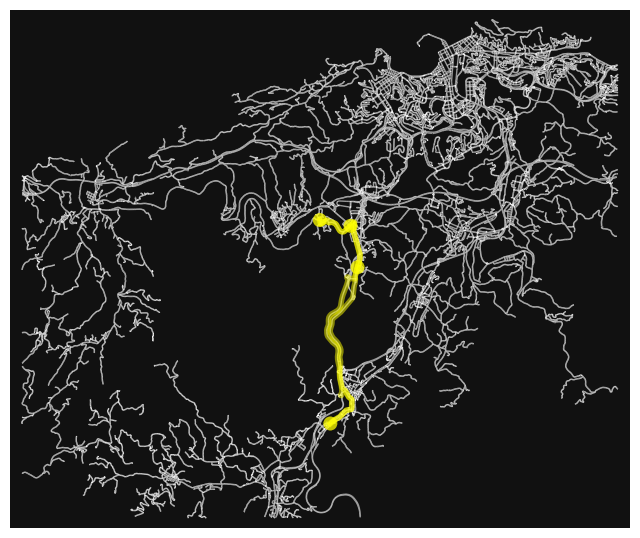

IndexError: list index out of range

In [6]:
%reset
#!pip install cplex
#!pip install docplex
#!pip install osmnx

import numpy as np
from docplex.mp.model import Model
# genetic algorithm search with constraints
import random
from numpy.random import randint

import osmnx as ox
import networkx as nx
import json

import itertools

import pandas as pd
from geopy import distance # Biblioteca para calculos geograficos
from geopy.geocoders import Nominatim
from geopy.point import Point

import folium
from folium import PolyLine
import matplotlib.pyplot as plt

import datetime


from google.colab import drive
drive.mount('/content/drive')

# directory where GTFS files will be saved
directory = '/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Proyecto Piloto_Eskuzaitzeta/GTFS_files/'

# Read the GTFS files
stops = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Proyecto Piloto_Eskuzaitzeta/DATOS_GIPUZKOA/gtfs_Zubieta/gtfs/stops.txt', delimiter=',')
stop_times = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Proyecto Piloto_Eskuzaitzeta/DATOS_GIPUZKOA/gtfs_Zubieta/gtfs/stop_times.txt', delimiter=',')
trips = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Proyecto Piloto_Eskuzaitzeta/DATOS_GIPUZKOA/gtfs_Zubieta/gtfs/trips.txt', delimiter=',')
routes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Proyecto Piloto_Eskuzaitzeta/DATOS_GIPUZKOA/gtfs_Zubieta/gtfs/routes.txt', delimiter=',')

# INPUTS
m_buses = 4 # number of available buses-> affects quality of solution for the Asymm. mTSP
#selec_trip_id = 32394  # 23 pts
#selec_trip_id =  32566 # 8 pts
selec_trip_id =  32402 # 13 pts -> just as an example, select the set of stops
#selec_trip_id =  32404 # 18 pts -> just as an example, select the set of stops

tol = 1.5
tol_dist = 0.2 # % difference between longest and shortest route
cont_limit = 40 # max number of iterations for convergence

CO2km = 1.12

def routes_list(A,m_b):
  ruta = {}
  for i in range(0, m_b):
    ruta['Bus_' + str(i+1)] = [0]
    j = i
    a = 10e10
    while a != 0:
        a = A[j,1]
        ruta['Bus_' + str(i+1)].append(a)
        #print(ruta['Bus_' + str(i+1)])
        j = np.where(A[:,0] == a)
        j = j[0][0]
        a = j
  return ruta

#def extract_RoutesMat(Xmat, Vec, n, pt, mb):
def extract_RoutesMat(Xmat, Vec, n, mb):
     paths0 = []
     out = np.zeros((n,n))
     #for (i, j) in zip(Vec, Vec):
     indeces = list(itertools.product(Vec, Vec))
     for ii in indeces:
        i = ii[0]
        j = ii[1]
        if Xmat[i][j] > 0:
           out[i][j] = Xmat[i][j]
           paths0.append([i,j])
     routes0 = routes_list(np.array(paths0),mb)
     """
     for i in routes0.keys():
        print(list(routes0[i]))
        if pt in routes0[i]:
           ruta = list(routes0[i])
     return ruta, out
     """
     return routes0, out

def check_Nbuses(Xmat):
  print('N buses going out from origin ={:3d}'.format(int(sum(Xmat[0,:]))))
  print('N buses returning to origin ={:3d}'.format(int(sum(Xmat[:,0]))))
  return

def check_UniqueStops(Xmat):
  for i in range(1,np.shape(Xmat)[0]):
     print('N routes out stop {:3d}: {:3d}'.format(i+1,int(sum(Xmat[i,:]))))
     print('N routes in stop {:3d}: {:3d}'.format(i+1,int(sum(Xmat[:,i]))))
  #print('Check all (should be 1):')
  #print((Xmat[1:,:].sum())/(np.shape(Xmat)[0]-1))
  return


def get_times(rutasEZ, points, Gra):
  route_times = []
  for i_routes in range(len(rutasEZ)):
      print('check')
      print(rutasEZ)
      print(rutasEZ[i_routes])
      origin = points[rutasEZ[i_routes][0]]
      origin_node = ox.distance.nearest_nodes(Gra, [origin[1]], [origin[0]])[0]
      path_length = 0
      path_time = 0
      for i_stops in rutasEZ[i_routes]:
          destination = points[i_stops]
          destination_node = ox.distance.nearest_nodes(Gra, [destination[1]], [destination[0]])[0]
          #Get the shortest path
          route = nx.shortest_path(Gra, origin_node, destination_node, weight='length') # Returns a list of nodes comprising the route
          for u, v in zip(route, route[1:]):
             edge_length = Gra.get_edge_data(u,v)[0]['length']   # Returns length in meters, e.g. 50.26
             path_length += edge_length
             edge_travel_time = Gra.get_edge_data(u,v)[0]['travel_time'] # Returns travel time in secs
             path_time += edge_travel_time
          #print('length (km): ',path_length/1000)
          #print('time (min): ',path_time/60)
      route_times.append(path_time/60)

  return route_times


# Merge trips and routes to have the name and the trip_id together
routes = routes[["route_id","route_long_name"]]
trips = trips[["route_id","trip_id"]]
trips = pd.merge(trips, routes, on='route_id', how='left')
trips = trips.drop(columns='route_id')
#print(trips)

# Merge stop_times and stops to have the trip_id with the stop latitude and longitud
stops = stops[["stop_id","stop_lat","stop_lon"]]
stop_times = stop_times[["trip_id","stop_id",]]
stops_coord = pd.merge(stop_times, stops, on='stop_id', how='left')
stops_coord = stops_coord.drop(columns='stop_id')
#print(stops_coord)

# Merge the two DataFrames
df = pd.merge(stops_coord, trips, on='trip_id', how='left')
#print(df)

Zubieta_routes = df[df['route_long_name'].str.contains('Zubieta', case=False)] # El parámetro case=False ignora mayúsculas y minúsculas
#print("Zubieta routes:")
#print(Zubieta_routes)

# Iterar a través de los trip_id únicos y guardar el trip seleccionado
for trip_id in Zubieta_routes['trip_id'].unique():
    print(trip_id)
    trip_df = Zubieta_routes[Zubieta_routes['trip_id'] == trip_id]
    print(len(trip_df))
    if trip_id ==  selec_trip_id:
       puntos = list(zip(trip_df['stop_lat'], trip_df['stop_lon']))

################################################
# Calculando la matriz de distancias
################################################
n = len(puntos)
C = np.zeros((n,n))

"""
for i in range(0, n):
    for j in range(0, len(puntos)):
        C[i,j] = distance.distance(puntos[i], puntos[j]).km
"""

ori_coord = puntos[0]
print()
print('Generating graph...')
#G = ox.graph_from_point(ori_coord, dist=10000, network_type="drive", simplify=True, retain_all=False)
G = ox.graph_from_point(ori_coord, dist=10000, network_type="drive", simplify=False, retain_all=False)
print('Graph completed!')
print()
print('Adding edge speeds, lengths and travelling speeds...')
#hwy_speeds = {"residential": 30, "secondary": 30, "tertiary": 30}
hwy_speeds = {"residential": 20, "unclassified": 30, "maxspeed": 50 }
#hwy_speeds = {"primary": 20, "residential": 20, "unclassified": 30, "maxspeed": 50 }
G = ox.add_edge_speeds(G, hwy_speeds)
#G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.distance.add_edge_lengths(G)
print('Adding edge speeds, lengths and travelling speeds completed!')

print()
print('Calculating distance matrix...')
for i in range(n):
   origin = puntos[i]
   origin_node = ox.distance.nearest_nodes(G, [origin[1]], [origin[0]])[0]
   for j in range(n):
     destination = puntos[j]
     destination_node = ox.distance.nearest_nodes(G, [destination[1]], [destination[0]])[0]
     #Get the shortest path
     path_length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
     C[i][j] = path_length/1000
print('Distance matrix calculated!')

# Mostrando la matriz de distancias
print('La matriz de distancia es:\n')
print(np.round(C,4))
n = np.shape(C)[0]

model=Model('mTSP')

## Variable xij
stops=range(n)
x=model.binary_var_matrix(keys1=stops,keys2=stops,name='x')
## Varible ui
u=model.integer_var_list(keys=stops, lb=0, ub=n,name='u')

model.minimize(model.sum(C[i,j] * x[i,j] for i in stops for j in stops))
model.add_constraint(model.sum(x[0 , j] for j in stops if j>0)==m_buses)
model.add_constraint(model.sum(x[i , 0] for i in stops if i>0)==m_buses)

for i in stops[1:]:
        model.add_constraint(model.sum(x[i , j] for j in stops )==1)

for j in stops[1:]:
        model.add_constraint(model.sum(x[i , j] for i in stops )==1)

for i in stops:
        model.add_constraint(x[i,i] == 0)

Ms = int(n/m_buses) # Ms = max number of stops visited by each bus.
                    # Choose Ms = n/m_buses for a balanced load distribution among buses
#Ms = n
for i in stops[1:]:
    for j in stops[1:]:
        if i != j:
          model.add_constraint(u[i]-u[j]+ Ms * x[i,j] <= Ms -1)
          #model.add_constraint(u[i]-u[j] + 1 <= (Ms -1)*(1-x[i,j]) )

model.add_constraint(u[0] == 1)
for i in stops[1:]:
       model.add_constraint(u[i] >= 2)
for i in stops[1:]:
       model.add_constraint(u[i] <= n) #---> Ms or n? With Ms algorithm keeps searching...


# ## Solve
solution = model.solve(log_output=False)
print('Objective function:')
print(solution.get_objective_value())
#solution.display()
X_sol = np.zeros((n,n))
for index, dvar in enumerate(solution.iter_variables()):
    if dvar.to_string().split('_')[0] == 'x':
       row, col = dvar.to_string().split('_')[1:]
       X_sol[int(row),int(col)] = solution[dvar]
       #print(index, dvar, dvar.to_string().split('_'), solution[dvar], solution.get_var_value(dvar))
ruta_EZ0, Xout = extract_RoutesMat(X_sol, stops, n, m_buses)
check_Nbuses(Xout)
check_UniqueStops(Xout)

print(ruta_EZ0)
#print(Xout)

ruta_EZ0 = list(ruta_EZ0.values())
cumul_dist_routes = []
for ii in range(len(ruta_EZ0)):
    dist_temp = []
    for jj in range(len(ruta_EZ0[ii])-1):
        i0 = ruta_EZ0[ii][jj]
        i1 = ruta_EZ0[ii][jj+1]
        dist_temp.append(C[i0][i1])
    cumul_dist_routes.append(sum(dist_temp))
print('Route cumulative lengths:')
print(cumul_dist_routes)
ind_max = cumul_dist_routes.index(max(cumul_dist_routes))
ind_min = cumul_dist_routes.index(min(cumul_dist_routes))
print()

stop = 0
cont = 0
converged = 0
objective = []
# generate 1D list:
ruta_EZ0_old = [0 for row in ruta_EZ0 for item in row]
while not stop:
     if solution:
        X_sol = np.zeros((n,n))
        for index, dvar in enumerate(solution.iter_variables()):
            if dvar.to_string().split('_')[0] == 'x':
               row, col = dvar.to_string().split('_')[1:]
               X_sol[int(row),int(col)] = solution[dvar]
               #print(index, dvar, dvar.to_string().split('_'), solution[dvar], solution.get_var_value(dvar))
        ruta_EZ0, Xout = extract_RoutesMat(X_sol, stops, n, m_buses)
        print('new routes:')
        print(ruta_EZ0)

        # find index of route with max cumulative length #######################
        # find index of route with min cumulative length
        ruta_EZ0 = list(ruta_EZ0.values())
        cumul_dist_routes = []
        for ii in range(len(ruta_EZ0)):
            dist_temp = []
            for jj in range(len(ruta_EZ0[ii])-1):
                i0 = ruta_EZ0[ii][jj]
                i1 = ruta_EZ0[ii][jj+1]
                dist_temp.append(C[i0][i1])
            cumul_dist_routes.append(sum(dist_temp))
        print('Route cumulative lengths:')
        print(cumul_dist_routes)
        ind_max = cumul_dist_routes.index(max(cumul_dist_routes))
        ind_min = cumul_dist_routes.index(min(cumul_dist_routes))
        ########################################################################

        if cont < cont_limit and not converged:
           C_max_list = []
           x_max_list = []
           for ii in range(len(ruta_EZ0[ind_max])-1):
               i0 = ruta_EZ0[ind_max][ii]
               i1 = ruta_EZ0[ind_max][ii+1]
               C_max_list.append(C[i0][i1])
               x_max_list.append((i0,i1))

           C_min_list = []
           x_min_list = []
           for ii in range(len(ruta_EZ0[ind_min])-1):
               i0 = ruta_EZ0[ind_min][ii]
               i1 = ruta_EZ0[ind_min][ii+1]
               C_min_list.append(C[i0][i1])
               x_min_list.append((i0,i1))

           model.add_constraint(  ( (model.sum(C_max_list[ii]*x[x_max_list[ii][0],x_max_list[ii][1]] for ii in range(len(x_max_list))) - model.sum(C_min_list[ii]*x[x_min_list[ii][0],x_min_list[ii][1]] for ii in range(len(x_min_list)))) <= tol_dist*model.sum(C_max_list[ii]*x[x_max_list[ii][0],x_max_list[ii][1]] for ii in range(len(x_max_list))) ) )
           #model.add_constraint(model.sum(C_max_list[ii]*x[x_max_list[ii][0],x_max_list[ii][1]] for ii in range(len(x_max_list))) <= 60 )
           #model.add_constraint(model.sum(C_min_list[ii]*x[x_min_list[ii][0],x_min_list[ii][1]] for ii in range(len(x_min_list))) >= 1 )
           print('indices max:')
           print(x_max_list)
           print('indices min:')
           print(x_min_list)

           try:
              solution0 = model.solve(log_output=False)
              #solution = model.solve(clean_before_solve=True,log_output=False) #---> try this
              print('Objective function:')
              print(solution0.get_objective_value())
              objective.append(solution0.get_objective_value())
              solution = solution0
              constr_exists = 1
              cont_constr = 0
              # does the following show the number of cumulated constraints?
              while(constr_exists is not None):
                  print('constraint: ')
                  constr_exists = model.get_constraint_by_index(cont_constr)
                  print(constr_exists)
                  cont_constr+=1
              dmax = np.sum(np.array(C_max_list))
              print('Cumulative distance of route covering Max dist:')
              print(dmax)
              dmin = np.sum(np.array(C_min_list))
              print('Cumulative distance of route covering Min dist:')
              print(dmin)
              print()

              # flatten list of routes to 1D list:
              ruta_EZ0 = [item for row in ruta_EZ0 for item in row]
              # check whether calculation has reached convergence
              if ruta_EZ0 == ruta_EZ0_old:
                 converged = 1
              ruta_EZ0_old = ruta_EZ0

           except:
              print('Solution not found!!!')
              stop = 1

        else:
           print('Solution converged or maximum number of iteration reached!')
           stop = 1

        cont+=1

     else:
         print('Solution not found at iteration: ', cont+1)
         stop = 1
#solution.display()
#solution.get_objective_value()


# Visualization ################################################################
G0=nx.Graph(name="buba")
#routes = [[2, 1, 4, 3, 11], [1, 0, 3, 11, 10], [10, 11, 3, 4, 1]]
edges = []
#for r in routes:
for r in ruta_EZ0:
    route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
    G0.add_nodes_from(r)
    G0.add_edges_from(route_edges)
    edges.append(route_edges)

print("Graph has %d nodes with %d edges" %(G0.number_of_nodes(),
G0.number_of_edges()))

pos = nx.spring_layout(G0)
nx.draw_networkx_nodes(G0,pos=pos)
nx.draw_networkx_labels(G0,pos=pos)
#colors = ['r', 'b', 'y', 'g']
from random import randint
colors = []
for i in range(len(edges)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
#linewidths = [20,10,5]
for ctr, edgelist in enumerate(edges):
    #nx.draw_networkx_edges(G0,pos=pos,edgelist=edgelist,edge_color = colors[ctr], width=linewidths[ctr])
    nx.draw_networkx_edges(G0,pos=pos,edgelist=edgelist,edge_color = colors[ctr])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Proyecto Piloto_Eskuzaitzeta/Optimized_routes.png')


#colors = ['red', 'blue', 'yellow']
routes = []
total_CO2 = 0.0
for ii in range(len(ruta_EZ0)):
    dist_temp = []
    length_route_i = 0
    for jj in range(len(ruta_EZ0[ii])-1):
           i0 = ruta_EZ0[ii][jj]
           i1 = ruta_EZ0[ii][jj+1]
           origin = puntos[i0]
           destination = puntos[i1]
           origin_node      = ox.distance.nearest_nodes(G, [origin[1]], [origin[0]])[0]
           destination_node = ox.distance.nearest_nodes(G, [destination[1]], [destination[0]])[0]
           route_i = nx.shortest_path(G, origin_node, destination_node, weight='length')
           length_route_i_temp = nx.shortest_path_length(G, origin_node, destination_node, weight='length')

           #dist_temp.append(origin_node)
           #if jj == 0:
           #   dist_temp = route_i.copy()
           #else:
           #   dist_temp = dist_temp + route_i.copy()
           dist_temp.append(route_i)
           length_route_i = length_route_i + length_route_i_temp
    routes.append(dist_temp)
    print('Length route (m) '+str(ii)+':',length_route_i)
    print('CO2 emissions of route '+str(ii)+':',(1./1000)*length_route_i*CO2km)
    total_CO2 = total_CO2 + (1./1000)*length_route_i*CO2km

    print()
print()
print('Total CO2 emissions: ',total_CO2)

"""
for i in range(len(routes)):
  #fig, ax = ox.plot_graph_routes(G, routes[i],edge_color=colors[i], bgcolor='w')
  fig, ax = ox.plot_graph_routes(G, routes[i], route_colors=colors[i], show=False,close=False,route_linewidth=0.1,node_size=0.1)
  #fig, ax = ox.plot_graph_route(G, routes[i], route_color=colors[i], show=False,close=False)
plt.show()
"""

"""
print(routes[0])
print(routes[1])
print(routes[2])
print(len(routes))
print(len(routes[0]))
"""
for i in range(len(routes)):
   fig, ax = ox.plot_graph_routes(G, routes[i],route_colors=colors[i],route_linewidth=0.1,node_size=0.1)
   #fig, ax = ox.plot_graph_routes(G, routes[1],route_colors=colors[1],route_linewidth=0.1,node_size=0.1)
   #fig, ax = ox.plot_graph_routes(G, routes[2],route_colors=colors[2],route_linewidth=0.1,node_size=0.1)
plt.show()

"""
routes = routes[0]+ routes[1] + routes[2]
print(routes)
print(len(routes))
print()
#colors0 = ['red']*len(routes[0])
#colors1 = ['blue']*len(routes[1])
#colors2 = ['yellow']*len(routes[2])
colors0 = ['red']*5
colors1 = ['blue']*5
colors2 = ['yellow']*5
colorss = colors0 + colors1 + colors2
print(len(colors0))
print(len(colors1))
print(len(colors2))
print(len(colorss))
fig, ax = ox.plot_graph_routes(G, routes, route_colors=colorss)
plt.show()
"""

"""
cont_stops = 0
trip_num = '0'
stops_coord_written = []
#ruta_EZ0 = list(ruta_EZ0.values())
for i_route in range(len(ruta_EZ0)): # loop over routes (= m_buses)
    ruta_stops_coord = []
    for i in range(len(ruta_EZ0[i_route])):
        ruta_stops_coord.append(puntos[ruta_EZ0[i_route][i]])
        print(i, ruta_EZ0[i_route][i], puntos[ruta_EZ0[i_route][i]])

    ori_coord = ruta_stops_coord[0]
    origin = ori_coord
    origin_node = ox.distance.nearest_nodes(G, [origin[1]], [origin[0]])[0]
    times = []
    for i in range(1,len(ruta_stops_coord)-1):
       destination = ruta_stops_coord[i]
       destination_node = ox.distance.nearest_nodes(G, [destination[1]], [destination[0]])[0]
       #route = nx.shortest_path(G, origin_node, destination_node)
       #print(G.nodes[origin_node])
       #print(G.nodes[destination_node])

       # replace the previous code with the following:
       route = nx.shortest_path(G, origin_node, destination_node, weight='length') # Returns a list of nodes comprising the route
       path_length = 0
       path_time = 0
       for u, v in zip(route, route[1:]):
           edge_length = G.get_edge_data(u,v)[0]['length']   # Returns length in meters, e.g. 50.26
           path_length += edge_length
           edge_travel_time = G.get_edge_data(u,v)[0]['travel_time'] # Returns travel time in secs
           path_time += edge_travel_time
       print('length (km): ',path_length/1000)
       print('time (min): ',path_time/60)
       times.append(path_time/60)


    #test = nx.shortest_path(G, origin_node, destination_node)
    #for edge in G.out_edges(test, data=True):
    #    print("\n=== Edge ====")
    #    print("Source and target node ID:", edge[:2])
    #    edge_attributes = edge[2]
    #    # remove geometry object from output
    #    edge_attributes_wo_geometry = {i:edge_attributes[i] for i in edge_attributes if i!='geometry'}
    #    print("Edge attributes:", json.dumps(edge_attributes_wo_geometry, indent=4))
    #fig, ax = ox.plot_graph_route(G, test)
    #plt.show()


    # agency.txt
    # agency_id,agency_name,agency_url,agency_timezone
    header = "agency_id,agency_name,agency_url,agency_timezone"
    if i_route == 0:
       with open(directory + 'agency.txt', 'w') as f:
           f.write(header + "\n")
           f.write('CSL_01, CSL@Gipuzkoa, https://www.media.mit.edu/groups/city-science/overview/, CET')
       f.close()

    # stops.txt
    # stop_id,stop_name,stop_lat,stop_lon, location_type, parent_station
    # parent_station = ID of principal station/stop? = origin of buses?
    # key = stop_id
    stop_ids = []
    header = "stop_id,stop_name,stop_lat,stop_lon, location_type, parent_station"
    geolocator = Nominatim(user_agent="coordinateconverter")
    if i_route == 0:
       parent_station = 'S0'
       with open(directory + 'stops.txt', 'w') as f:
           f.write(header + "\n")
           f.close()
    with open(directory + 'stops.txt', 'a') as f:
           for i in range(len(ruta_stops_coord)):
               stop_id = 'S' + str(cont_stops)
               lat = ruta_stops_coord[i][0]
               lon = ruta_stops_coord[i][1]
               stop_name = geolocator.reverse(Point(lat,lon))
               stop_name0 = str(stop_name).split(',')[0]
               stop_name1 = str(stop_name).split(',')[1][1:]
               stop_name = stop_name0 + '_' + stop_name1
               if [lat, lon] not in stops_coord_written:
                  if i_route == 0 and i == 0:
                     f.write(stop_id + ', ' + stop_name + ', ' + str(lat) + ', ' + str(lon) + ', 0, ' + ' ' + "\n")
                  else:
                     f.write(stop_id + ', ' + stop_name + ', ' + str(lat) + ', ' + str(lon) + ', 0, ' + parent_station + "\n")
                  stops_coord_written.append([lat,lon])
                  stop_ids.append(stop_id)
                  #print('stop_id: ',stop_id)
                  cont_stops+=1
    f.close()

    # routes.txt
    # route_id,route_short_name,route_long_name,route_desc,route_type
    # key = route_id
    route_id = 'EZ' + str(i_route)
    route_type = '3' # bus
    header = "route_id,route_short_name,route_long_name,route_desc,route_type"
    if i_route == 0:
       with open(directory + 'routes.txt', 'w') as f:
           f.write(header + "\n")
           f.close()
    with open(directory + 'routes.txt', 'a') as f:
           f.write(route_id + ', ' + 'Esku_' + route_id + ', Eskuzaitzeta ' + str(i_route) + ', ' + 'The "Eskuzaitzeta" route serves workers of the industrial park,' + route_type + '\n')
           f.close()

    # trips.txt
    # route_id,service_id,trip_id,trip_headsign,block_id
    # key = trip_id
    trip_id = 'EZ_rou' + str(i_route) + '_tr' + trip_num #'EZ0'
    service_id = '1'
    header = 'route_id, trip_id, service_id'
    if i_route == 0:
       with open(directory + 'trips.txt', 'w') as f:
           f.write(header + "\n")
           f.close()
    with open(directory + 'trips.txt', 'a') as f:
        f.write(route_id + ', ' + trip_id + ', ' + service_id + '\n' )
    f.close()

    # stop_times.txt
    # key = stop_sequence
    header = "trip_id,arrival_time,departure_time,stop_id,stop_sequence"
    if i_route == 0:
       date_and_time = datetime.datetime.now()+datetime.timedelta(hours=1)
       with open(directory + 'stop_times.txt', 'w') as f:
           f.write(header + "\n")
           #t0 = date_and_time.strftime("%H:%M:%S")
           #f.write(trip_id + ", " + t0 + ', ' + t0 + ', ' + 'S0' + ', ' + '1' + "\n")
           f.close()

    with open(directory + 'stop_times.txt', 'a') as f:
        for i in range(len(times)):
            time_change = datetime.timedelta(minutes=2)
            new_time = date_and_time + time_change
            t0 = date_and_time.strftime("%H:%M:%S")
            t1 = new_time.strftime("%H:%M:%S")
            if i_route == 0 and i == 0:
                  f.write(trip_id + ", " + t0 + ', ' + t0 + ', ' + stop_ids[0] + ', ' + '1' + "\n")
                  if len(times) == 1:
                     time_change = datetime.timedelta(minutes=times[i])
                     new_time = date_and_time + time_change
                     t0 = new_time.strftime("%H:%M:%S")
                     time_change = datetime.timedelta(minutes=2)
                     new_time = new_time + time_change
                     t1 = new_time.strftime("%H:%M:%S")
                     f.write(trip_id + ", " + t0 + ', ' + t1 + ', ' + stop_ids[1] + ', ' + '2' + "\n")
            else:
               f.write(trip_id + ", " + t0 + ', ' + t1 + ', ' + stop_ids[i] + ', ' + str(i+2) + "\n")
            time_change = datetime.timedelta(minutes=times[i])
            date_and_time = new_time + time_change
            #print('stop times, stop_id: ', i_route, i, stop_ids[i])
    f.close()

"""